# PayNet Assessment 
# Data Cleaning & Visualization using PySpark

#### Prepared by: Ainur Afifah

### Steps:
1. Initialize session 
2. Read JSON into dataframe
3. Convert JSON into a tabular format (Flatten the JSON)
    1. personal_details
    2. address
4. Separate person_name into first name & last name
5. Convert timestamp into UTC +8
6. Other normalizations:
    1. dob
    2. merchant name & fraud flag
    3. cc_bic -> bank_code, country_code, location_code, branch_code
    4. amt column is saved in string -> amount_clean to make sure no negative values
    5. is_fraud column is saved in string -> so it is converted into boolean
    6. Remove nulls, missing values and duplicates in selected columns
7. Do charts and visualization

In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json, split, concat, lit, substring, regexp_extract, abs
from pyspark.sql.functions import date_format, from_unixtime, to_timestamp, from_utc_timestamp
from pyspark.sql.functions import regexp_replace, when, array_contains, size, get_json_object
from pyspark.sql.functions import to_date, year, month, dayofmonth
from pyspark.sql.types import StringType, StructType, StructField
import re
from IPython.display import display



spark = SparkSession.builder.appName("cc-sample-data").getOrCreate()

json_file_path = "/Users/ainurafifah/Desktop/PROJECTS/portfolio/PayNet/cc_sample_transaction.json"


try:
    df = spark.read.option("multiline", "true").json(json_file_path)
    df = spark.read.json(json_file_path)

    
    print("Full schema:")
    df.printSchema()
    
    # Convert timestamp to UTC+8
    # Set timezone configuration
    spark.conf.set("spark.sql.session.timeZone", "UTC+8")
    
    df = df.withColumn(
    "trans_date_trans_time_utc8",
    to_timestamp(col("trans_date_trans_time"))
            )
    
    df = df.withColumn(
    "merch_eff_time_utc8",from_unixtime(col("merch_eff_time") / 1000000))

    df = df.withColumn(
    "merch_last_update_time_utc8",
    from_unixtime(col("merch_last_update_time") / 1000))
    
    # Split cc_bic column into 4 separate columns
    df = df.withColumn("bank_code", substring(col("cc_bic"), 1, 4))
    df = df.withColumn("country_code", substring(col("cc_bic"), 5, 2))
    df = df.withColumn("location_code", substring(col("cc_bic"), 7, 2))
    df = df.withColumn("branch_code", substring(col("cc_bic"), 9, 3))
    
    # Split merchant column into name and fraud flag
    df = df.withColumn("fraud_flag",
       regexp_extract(col("merchant"), "^fraud_", 0))
    df = df.withColumn("merchant_name",
       regexp_extract(col("merchant"), "[^_]+$", 0))
    
    df = df.withColumn("derived_fraud_flag",
    when(col("merchant").startswith("fraud_"), True).otherwise(False))
                       
    df = df.withColumn("is_fraud_bool",
       col("is_fraud").cast("boolean"))

    df = df.withColumn("amount_clean",
       abs(col("amt").cast("decimal(10,2)"))).filter(col("amount_clean") < 100000)
    
    
    # Flattening the JSON
    # Define schema for nested structures
    address_schema = StructType([
                        StructField("street", StringType()),
                        StructField("city", StringType()),
                        StructField("state", StringType()),
                        StructField("zip", StringType())
                        ])

    personal_detail_schema = StructType([
                        StructField("person_name", StringType()),
                        StructField("gender", StringType()),
                        StructField("address", StringType()),
                        StructField("lat", StringType()),
                        StructField("long", StringType()),
                        StructField("city_pop", StringType()),
                        StructField("job", StringType()),   
                        StructField("dob", StringType())
                        ])

    # Parse nested JSON strings
    df_parsed = df.withColumn("personal_detail_parsed", 
                             from_json("personal_detail", personal_detail_schema))
    
    df_final = df_parsed.withColumn("address_parsed",
            from_json(
                regexp_replace(col("personal_detail_parsed.address"), r'\\"', '"'),
                address_schema))

    # Handling person_name column split
    DELIMITERS = [",", "@", "/", "!", "\\\\"]
    delimiter_pattern = "|".join([re.escape(d) for d in DELIMITERS])
    
    df_final = df_final.withColumn(
    "normalized_name",
        regexp_replace(col("personal_detail_parsed.person_name"), delimiter_pattern, "|")
    ).withColumn(
        "name_parts",
        split(col("normalized_name"), "\\|")
    )
    
    spark.conf.set("spark.sql.debug.maxToStringFields", "1000")

    # Flatten all nested structures
    flattened_df = df_final.select(
        "Unnamed: 0",
        "trans_date_trans_time_utc8",
        "cc_num",
        "merchant",
        "merchant_name",
        "fraud_flag",
        "derived_fraud_flag",
        "is_fraud_bool",
        "category",
        "amount_clean",
      
        when((size(col("name_parts")) > 0) & (col("name_parts")[0] != ""), 
            col("name_parts")[0]
        ).otherwise(lit(None)).alias("first"),
        
        when((size(col("name_parts")) > 1) & (col("name_parts")[1] != ""),
            col("name_parts")[1]
        ).otherwise(lit(None)).alias("last"),
        
             
        col("personal_detail_parsed.gender").alias("gender"),
        col("address_parsed.street").alias("street"),
        col("address_parsed.city").alias("city"),
        col("address_parsed.state").alias("state"),
        col("address_parsed.zip").alias("zip"),
        col("personal_detail_parsed.lat").alias("lat"),
        col("personal_detail_parsed.long").alias("long"),
        col("personal_detail_parsed.city_pop").alias("city_pop"),
        col("personal_detail_parsed.job").alias("job"),
        year(to_date(col("personal_detail_parsed.dob"))).alias("birth_year"),
        month(to_date(col("personal_detail_parsed.dob"))).alias("birth_month"),
        dayofmonth(to_date(col("personal_detail_parsed.dob"))).alias("birth_day"),
        "trans_num",
        "merch_lat",
        "merch_long",
        "merch_zipcode",
        "merch_eff_time_utc8",
        "merch_last_update_time_utc8",
        "cc_bic",
        "bank_code",
        "country_code",
        "location_code",
        "branch_code"     
    ).drop("normalized_name", "name_parts")

    print("Flattened schema:")
    flattened_df.printSchema()
    
    print("\nSample flattened data:")
    flattened_df.show(5, truncate=False, vertical=True)
    
    
except Exception as e:
    print(f"Error reading JSON file: {e}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/05 12:35:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Full schema:
root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)

Flattened schema:
root
 |-- Unnamed: 0: string (nullable = true)
 |-- trans_date_trans_time_utc8: timestamp (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- fraud_flag: string (nullable = true)
 |-- derived_fraud_flag: boolean (nullable = fal

In [6]:
from pyspark.sql.functions import count, when
from pyspark.sql import DataFrame

def handle_nulls(df: DataFrame) -> DataFrame:
    """Handle null/missing values with column-specific strategies"""
    # Define treatment for each column type
    return df.na.fill({
        # String columns
        "merchant_name": "unknown_merchant",
        "first": "unknown_first",
        "last": "unknown_last",
        "gender": "U",  # 'U' for unknown
        "street": "unknown_street",
        "city": "unknown_city",
        "state": "unknown_state",
        "job": "unknown_job",
        
        # Numeric columns
        "amount_clean": 0.0,
        "lat": 0.0,
        "long": 0.0,
        "city_pop": 0,
        "birth_year": 1900,  # Default for unknown birth year
        "birth_month": 1,
        "birth_day": 1,
        
        # Boolean columns
        "fraud_flag": False,
        "derived_fraud_flag": False,
        "is_fraud_bool": False,
        
        # Code columns
        "zip": "00000",
        "merch_zipcode": "00000",
        "bank_code": "XXXX",
        "country_code": "XX",
        "location_code": "XX",
        "branch_code": "XXX"
    })


def handle_duplicates(df: DataFrame) -> DataFrame:
    """Identify and remove duplicates with key columns"""
    # Define uniqueness criteria
    key_columns = ["trans_num", "cc_num", "trans_date_trans_time_utc8"]
    
    # Mark duplicates
    from pyspark.sql.window import Window
    window = Window.partitionBy(key_columns).orderBy("merch_eff_time_utc8")
    
    df = df.withColumn("is_duplicate", 
                      (count("*").over(window) > 1))
    
    # Optional: Show duplicates before removal
    df.filter(col("is_duplicate")).show()
    
    # Keep only first occurrence
    return df.dropDuplicates(key_columns).drop("is_duplicate")

def validate_data(df: DataFrame) -> None:
    """Run comprehensive data quality checks"""
    # Null check
    null_counts = df.select([
        count(when(col(c).isNull() | (col(c) == ""), c)).alias(c) 
        for c in df.columns
    ])
    print("Null/empty value counts:")
    null_counts.show(vertical=True)
    
    # Duplicate check
    duplicate_count = df.count() - df.dropDuplicates(["trans_num"]).count()
    print(f"\nDuplicate transactions: {duplicate_count}")
    
    # Value range checks
    df.select(
        count(when(col("amount_clean") < 0, True)).alias("negative_amounts"),
        count(when(col("birth_year") < 1900, True)).alias("invalid_birth_years"),
        count(when(~col("country_code").rlike("^[A-Z]{2}$"), True)).alias("invalid_country_codes")
    ).show()

In [7]:
# Apply all cleaning steps
cleaned_df = (flattened_df.transform(handle_nulls).transform(handle_duplicates))

# Validate results
validate_data(cleaned_df)

+----------+--------------------------+------+--------+-------------+----------+------------------+-------------+--------+------------+-----+----+------+------+----+-----+---+---+----+--------+---+----------+-----------+---------+---------+---------+----------+-------------+-------------------+---------------------------+------+---------+------------+-------------+-----------+------------+
|Unnamed: 0|trans_date_trans_time_utc8|cc_num|merchant|merchant_name|fraud_flag|derived_fraud_flag|is_fraud_bool|category|amount_clean|first|last|gender|street|city|state|zip|lat|long|city_pop|job|birth_year|birth_month|birth_day|trans_num|merch_lat|merch_long|merch_zipcode|merch_eff_time_utc8|merch_last_update_time_utc8|cc_bic|bank_code|country_code|location_code|branch_code|is_duplicate|
+----------+--------------------------+------+--------+-------------+----------+------------------+-------------+--------+------------+-----+----+------+------+----+-----+---+---+----+--------+---+----------+------

-RECORD 0------------------------------
 Unnamed: 0                  | 0       
 trans_date_trans_time_utc8  | 0       
 cc_num                      | 0       
 merchant                    | 0       
 merchant_name               | 0       
 fraud_flag                  | 0       
 derived_fraud_flag          | 0       
 is_fraud_bool               | 0       
 category                    | 0       
 amount_clean                | 0       
 first                       | 0       
 last                        | 0       
 gender                      | 0       
 street                      | 0       
 city                        | 0       
 state                       | 0       
 zip                         | 0       
 lat                         | 0       
 long                        | 0       
 city_pop                    | 0       
 job                         | 0       
 birth_year                  | 0       
 birth_month                 | 0       
 birth_day                   | 0       



Duplicate transactions: 0


+----------------+-------------------+---------------------+
|negative_amounts|invalid_birth_years|invalid_country_codes|
+----------------+-------------------+---------------------+
|               0|                  0|               432980|
+----------------+-------------------+---------------------+



In [8]:
cleaned_df.show(5, vertical=True)

-RECORD 0-------------------------------------------
 Unnamed: 0                  | 534019               
 trans_date_trans_time_utc8  | 2019-08-17 21:26:16  
 cc_num                      | 374930071163758      
 merchant                    | fraud_Reichert, R... 
 merchant_name               | Reichert, Rowe an... 
 fraud_flag                  | fraud_               
 derived_fraud_flag          | true                 
 is_fraud_bool               | false                
 category                    | shopping_net         
 amount_clean                | 8.45                 
 first                       | Daniel               
 last                        | Escobar              
 gender                      | M                    
 street                      | 61390 Hayes Port     
 city                        | Romulus              
 state                       | MI                   
 zip                         | 48174                
 lat                         | 42.2203        

In [14]:
cleaned_df.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- trans_date_trans_time_utc8: timestamp (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- merchant_name: string (nullable = false)
 |-- fraud_flag: string (nullable = false)
 |-- derived_fraud_flag: boolean (nullable = false)
 |-- is_fraud_bool: boolean (nullable = false)
 |-- category: string (nullable = true)
 |-- amount_clean: decimal(10,2) (nullable = true)
 |-- first: string (nullable = false)
 |-- last: string (nullable = false)
 |-- gender: string (nullable = false)
 |-- street: string (nullable = false)
 |-- city: string (nullable = false)
 |-- state: string (nullable = false)
 |-- zip: string (nullable = false)
 |-- lat: string (nullable = false)
 |-- long: string (nullable = false)
 |-- city_pop: string (nullable = false)
 |-- job: string (nullable = false)
 |-- birth_year: integer (nullable = false)
 |-- birth_month: integer (nullable = false)
 |-- birth_day: integer (nullabl

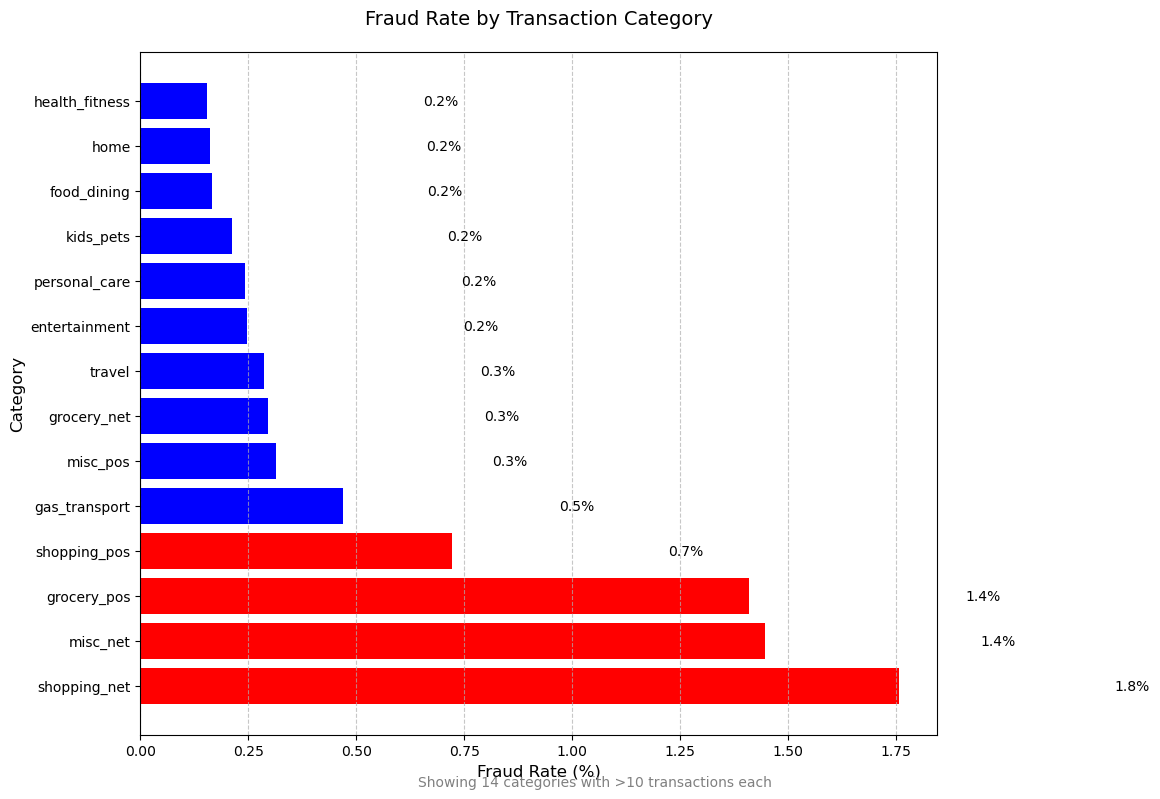

In [15]:
from pyspark.sql.functions import col, when, sum, count, avg
import matplotlib.pyplot as plt

# Calculate fraud rates with proper boolean handling
category_fraud = df.groupBy("category") \
    .agg(
        avg(col("is_fraud_bool").cast("integer")).alias("fraud_rate"),  # More efficient than sum/count
        count("*").alias("total_transactions")
    ).orderBy("fraud_rate", ascending=False).toPandas()

# Filter out categories with low transaction counts (optional)
category_fraud = category_fraud[category_fraud['total_transactions'] > 10]  # Adjust threshold as needed

# Visualization with improved formatting
plt.figure(figsize=(12, 8))
bars = plt.barh(
    category_fraud['category'], 
    category_fraud['fraud_rate']*100,
    color=['red' if rate > category_fraud['fraud_rate'].mean() else 'blue' 
           for rate in category_fraud['fraud_rate']]
)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5,  # x-position
             bar.get_y() + bar.get_height()/2,  # y-position
             f'{width:.1f}%',  # text
             va='center')

plt.title("Fraud Rate by Transaction Category", fontsize=14, pad=20)
plt.xlabel("Fraud Rate (%)", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add footnote about transaction counts
plt.figtext(0.5, 0.01, 
           f"Showing {len(category_fraud)} categories with >10 transactions each", 
           ha="center", fontsize=10, color='gray')

plt.show()

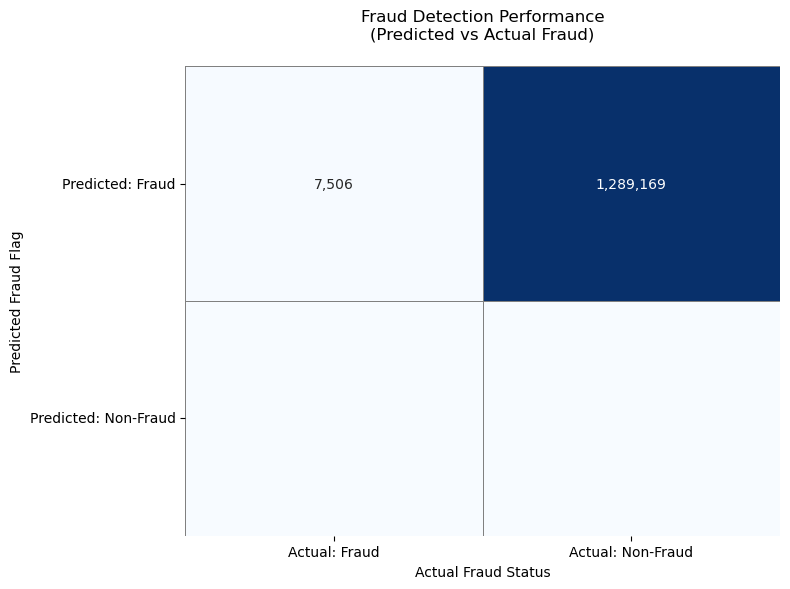

In [17]:
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create confusion matrix - ensure all boolean combinations are included
confusion_df = df.groupBy(
    when(col("derived_fraud_flag"), "Predicted: Fraud")
     .otherwise("Predicted: Non-Fraud").alias("predicted"),
    when(col("is_fraud_bool"), "Actual: Fraud")
     .otherwise("Actual: Non-Fraud").alias("actual")
).count().orderBy("predicted", "actual").toPandas()

# Pivot the data for heatmap
confusion_pivot = confusion_df.pivot(
    index="predicted",
    columns="actual",
    values="count"
).fillna(0)  # Fill any missing combinations with 0

# Ensure all combinations exist (in case some are missing from data)
for pred in ["Predicted: Fraud", "Predicted: Non-Fraud"]:
    for act in ["Actual: Fraud", "Actual: Non-Fraud"]:
        if act not in confusion_pivot.columns:
            confusion_pivot[act] = 0
        if pred not in confusion_pivot.index:
            confusion_pivot.loc[pred] = 0

# Reorder columns and rows for standard confusion matrix format
confusion_pivot = confusion_pivot.reindex(
    ["Predicted: Fraud", "Predicted: Non-Fraud"],
    columns=["Actual: Fraud", "Actual: Non-Fraud"]
)

# Create heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    confusion_pivot, 
    annot=True, 
    fmt=',d',  # Format with thousands separators
    cmap='Blues',
    cbar=False,
    linewidths=0.5,
    linecolor='gray'
)

# Add titles and labels
plt.title("Fraud Detection Performance\n(Predicted vs Actual Fraud)", pad=20)
plt.xlabel("Actual Fraud Status")
plt.ylabel("Predicted Fraud Flag")

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

<Axes: xlabel='hour'>

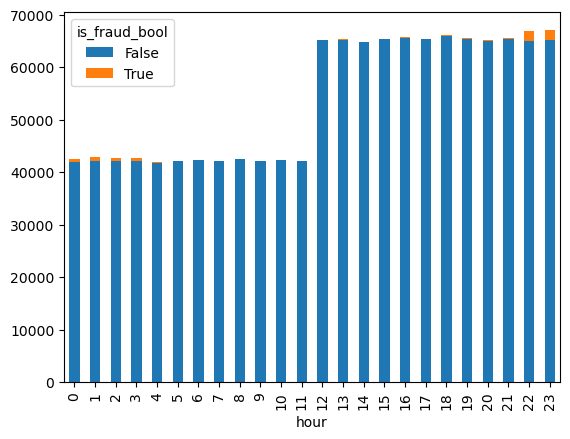

In [30]:
from pyspark.sql.functions import hour

df.withColumn("hour", 
              hour("trans_date_trans_time_utc8")).groupBy("hour", "is_fraud_bool").count().toPandas().pivot(
    index="hour", columns="is_fraud_bool", values="count").plot(kind='bar', stacked=True)

<Axes: xlabel='hour'>

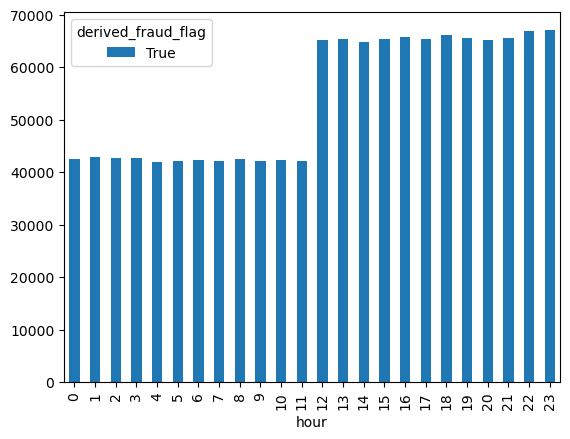

In [31]:
from pyspark.sql.functions import hour

df.withColumn("hour", 
              hour("trans_date_trans_time_utc8")).groupBy("hour", "derived_fraud_flag").count().toPandas().pivot(
    index="hour", columns="derived_fraud_flag", values="count").plot(kind='bar', stacked=True)

In [23]:
import folium
from folium.plugins import HeatMap

fraud_locations = df.filter(col("is_fraud_bool")).select("merch_lat", "merch_long").toPandas()
m = folium.Map(location=[39.8, -98.6], zoom_start=4)
HeatMap(fraud_locations[['merch_lat', 'merch_long']].values).add_to(m)

m

array([[<Axes: title={'center': 'time_since_last'}>]], dtype=object)

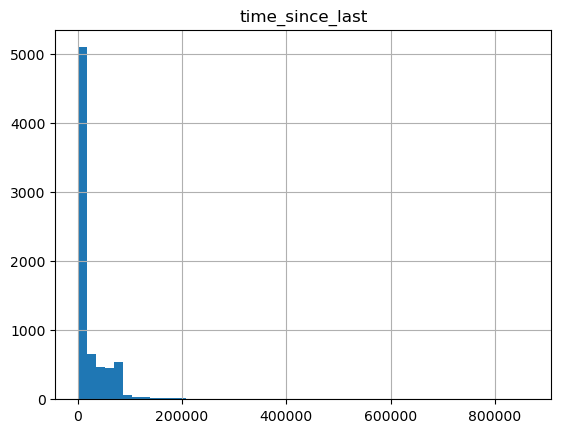

In [48]:
from pyspark.sql.window import Window
from pyspark.sql.functions import unix_timestamp, lag, col

window = Window.partitionBy("cc_num").orderBy("trans_date_trans_time_utc8")

time_since_fraud = (
    df.withColumn(
        "time_since_last",
        unix_timestamp(col("trans_date_trans_time_utc8")) - 
        unix_timestamp(lag("trans_date_trans_time_utc8").over(window))
    )
    .filter(col("is_fraud_bool"))
    .select("time_since_last")
    .toPandas()
)

time_since_fraud.hist(bins=50)